In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from collections import defaultdict
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
cases_text_onlyspeaker_df = pd.read_csv("cases_text_onlyspeaker.csv")
cases_text_onlyspeaker_df.head()

,new_name,sentence,sentence_clean,topic_mentioned,sentiment,prob_score_neg,prob_score_neutral,prob_score_pos,has_parking,has_econactivity,...,sent_voice_mentioned,sentpol_voice_mentioned,prob_pos_voice_mentioned,prob_neg_voice_mentioned,positive_voice_mentioned,negative_voice_mentioned,num_voice_mentioned,num_sentences,sentence_lower,count_my_name
0,09-12-2017audio_6ZA-2017-210-CU-1A,My name is Jerry Newman.,My name is Jerry Newman.,NaN,NaN,NaN,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,my name is jerry newman.,1
1,09-12-2017audio_6ZA-2017-210-CU-1A,"Thank you, President Chunkham, members of the ...","Thank you, President Chunkham, members of the ...",NaN,NaN,NaN,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,"thank you, president chunkham, members of the ...",0
2,09-12-2017audio_6ZA-2017-210-CU-1A,The question that is asked and that was asked ...,The question that is asked and that was asked ...,NaN,NaN,NaN,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,the question that is asked and that was asked ...,0
3,09-12-2017audio_6ZA-2017-210-CU-1A,And I think Mr. Chang made an adequate descrip...,And I think Mr. Chang made an adequate descrip...,NaN,NaN,NaN,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,and i think mr. chang made an adequate descrip...,0
4,09-12-2017audio_6ZA-2017-210-CU-1A,We started thinking through a business plan an...,We started thinking through a business plan an...,NaN,NaN,NaN,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,we started thinking through a business plan an...,0


Load Sentence Embedding Model

In [3]:
model = SentenceTransformer('all-MiniLM-L6-v2')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Get Embeddings

In [4]:
def get_embeddings(column):
  parking_rows = cases_text_onlyspeaker_df[cases_text_onlyspeaker_df[column] == 1]
  all_sentences = parking_rows["sentence"].tolist()
  
  return model.encode(all_sentences), all_sentences

Get Optimal k Clusters (Elbow Test)

In [5]:
def elbow_test(embeddings):
  inertias = []
  k_values = range(1, 20)

  for k in k_values:
      clustering_model = KMeans(n_clusters=k, random_state=0)
      clustering_model.fit(embeddings)
      inertias.append(clustering_model.inertia_)

  plt.figure(figsize=(8, 4))
  plt.plot(k_values, inertias, 'bo-')
  plt.xlabel('Number of Clusters (k)')
  plt.ylabel('Inertia (Sum of Squared Distances)')
  plt.title('Elbow Test for Optimal k')
  plt.grid(True)
  plt.show()

K-means Classifier

In [6]:
def k_means_classifier(embeddings, num_clusters = 8, seed = 42):
  clustering_model = KMeans(n_clusters=num_clusters, random_state=seed)
  clustering_model.fit(embeddings)
  clusters = clustering_model.labels_

  return clusters

Visualize Clusters

In [7]:
def pca_plot(embeddings, clusters):
  pca = PCA(n_components=3)
  pca_result = pca.fit_transform(embeddings)

  fig = plt.figure(figsize=(10, 7))
  ax = fig.add_subplot(111, projection='3d')

  scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=clusters, cmap='rainbow', alpha=0.7)
  ax.view_init(elev=30, azim=120)


  ax.set_title('3D PCA of Sentence Embeddings with K-Means Clustering')
  ax.set_xlabel('PCA Component 1')
  ax.set_ylabel('PCA Component 2')
  ax.set_zlabel('PCA Component 3')

  plt.colorbar(scatter, ax=ax, label='Cluster ID')
  plt.show()

In [18]:
def example_sentences(clustered_sentences, num_clusters, samples):
  for i in range(num_clusters):
      print(f"\nCluster {i}:")
      example_sentences = clustered_sentences[clustered_sentences['Cluster'] == i]['Sentence'].sample(samples)
      for sentence in example_sentences:
          print(f"- {sentence}")

In [9]:
def display_cluster_breakdown(clusters_df, cluster_labels):
  cluster_counts = clusters_df['Cluster'].value_counts().sort_index()
  total_sentences = cluster_counts.sum()

  cluster_data = []
  for cluster_num, count in cluster_counts.items():
      percentage = (count / total_sentences) * 100
      label = cluster_labels[cluster_num]
      cluster_data.append({
          'Cluster': cluster_num,
          'Pct of Sentences': f"{percentage:.2f}%",
          'Manual Guessed Label': label
      })

  cluster_breakdown_df = pd.DataFrame(cluster_data)
  cluster_breakdown_df.set_index('Cluster', inplace=True)

  return cluster_breakdown_df

Topic: Parking

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


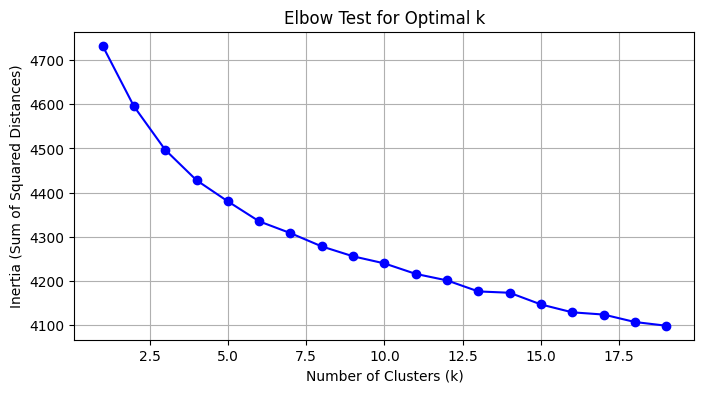

In [10]:
parking_embeddings, parking_sentences = get_embeddings('has_parking')
elbow_test(parking_embeddings)

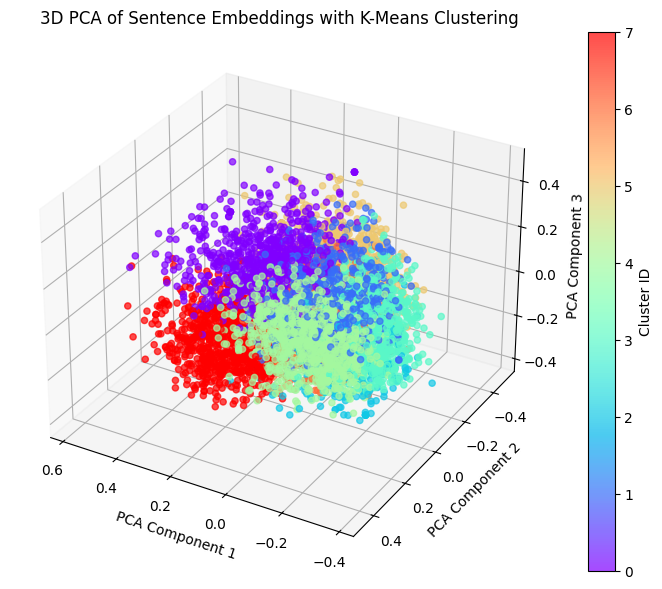

In [11]:
parking_num_clusters = 8
parking_seed = 42
parking_clusters = k_means_classifier(parking_embeddings, parking_num_clusters, parking_seed)
parking_clusters_df = pd.DataFrame({'Sentence': parking_sentences, 'Cluster': parking_clusters})
pca_plot(parking_embeddings, parking_clusters)

In [19]:
parking_example_sentences = 4
example_sentences(parking_clusters_df, parking_num_clusters, parking_example_sentences)


Cluster 0:
- Michael mentioned and we see a couple of letters here regarding those other projects that show on the first floor windows and behind it, its parking.
- What you dont have, we put together late yesterday was a revised and final landscape plan that includes the citys requirement for a treat for every four spaces and that the parking lots would all be shaded to 50 within 10 years.
- There is some subterranean parking on that blockpredominantly the buildings range from one to three story and I would say 28 feet to 42 feet.
- So I know theres a lot of concerns about height, but majority of the development here is really surface parking, and it would be remiss for us to imagine that no new development is going to happen in this area anytime soon.

Cluster 1:
- You found a significant impact, a possible significant impact caused by this parking configuration.
- So were looking at open space where theyre locating their parking and things of that nature.
- Were happy to discuss mo

In [13]:
parking_cluster_labels = {
    0: "*parking design/infrastructure relative to the proposed project",
    1: "",
    2: "*concern about lack of parking",
    3: "*issues and inadequacies of parking on community",
    4: "physical location of parking",
    5: "*beauracracy, compliance with regulations, application",
    6: "parking regulations and requirements for different zones or businesses",
    7: "*specific amount parking space requirements"
}


parking_cluster_breakdown_df = display_cluster_breakdown(parking_clusters_df, parking_cluster_labels)
parking_cluster_breakdown_df

,Pct of Sentences,Manual Guessed Label
Cluster,,
0,12.12%,*parking design/infrastructure relative to the...
1,10.67%,
2,5.28%,*concern about lack of parking
3,13.19%,*issues and inadequacies of parking on community
4,14.88%,physical location of parking
5,15.00%,"*beauracracy, compliance with regulations, app..."
6,16.47%,parking regulations and requirements for diffe...
7,12.40%,*specific amount parking space requirements


Topic: Nuisance

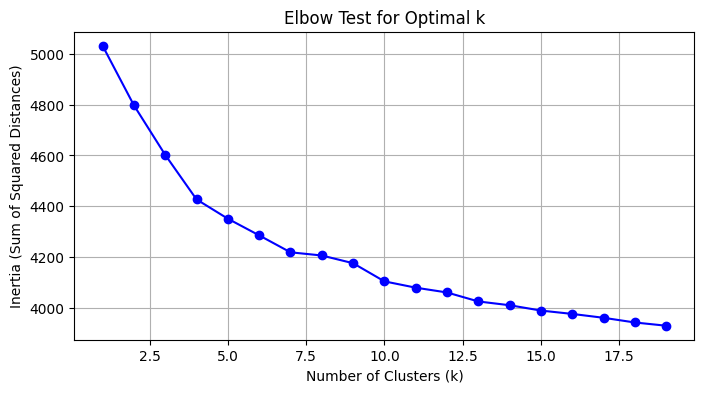

In [14]:
nuisance_embeddings, nuisance_sentences = get_embeddings('has_nuisance')
elbow_test(nuisance_embeddings)

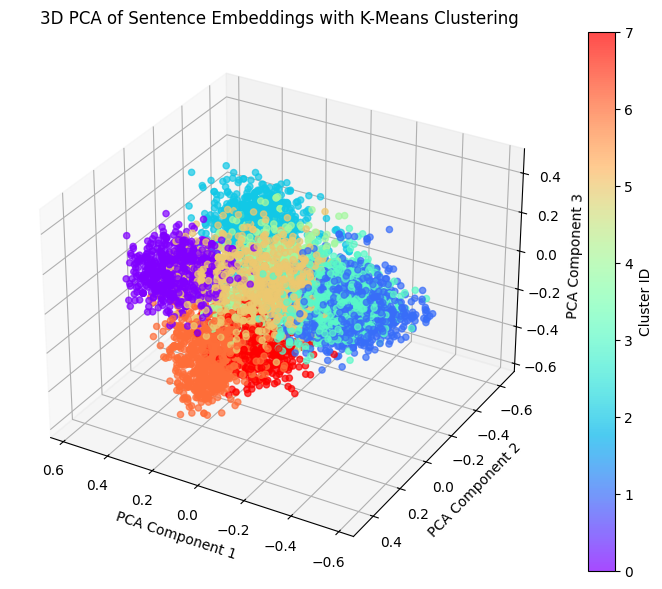

In [15]:
nuisance_num_clusters = 8
nuisance_seed = 42
nuisance_clusters = k_means_classifier(nuisance_embeddings, nuisance_num_clusters, nuisance_seed)
nuisance_clusters_df = pd.DataFrame({'Sentence': nuisance_sentences, 'Cluster': nuisance_clusters})
pca_plot(nuisance_embeddings, nuisance_clusters)

In [20]:
nuisance_example_sentences = 4
example_sentences(nuisance_clusters_df, nuisance_num_clusters, nuisance_example_sentences)


Cluster 0:
- There must be somesome open space on that project.
- So we would ask that these changes be accommodated in order to provide for the tax benefits associated with dedication of public open spacestated in the staff report, this property is 91 acres and is currently zoned A1.
- So as long as they dont build on the patio, even though its private to use, I I couldnt say for sure whether or not that would still count towards the required open space.
- But I think its interesting about this project and I asked staff to talk about is that this has a pointpublic, open space level on the second, on the podium level above the street frontage as well that theyre trying to bring in a second level of community.

Cluster 1:
- Specifically about busing or traffic.
- A traffic study may be required of a development due to environmental lawor city regulations and its purpose is to predict and analyze the circulation and congestion impacts of the project generated traffic.
- The Department o

In [17]:
nuisance_cluster_labels = {
    0: "*nuisance design/infrastructure relative to the proposed project",
    1: "",
    2: "*concern about lack of nuisance",
    3: "*issues and inadequacies of nuisance on community",
    4: "physical location of nuisance",
    5: "*beauracracy, compliance with regulations, application",
    6: "nuisance regulations and requirements for different zones or businesses",
    7: "*specific amount nuisance space requirements"
}


nuisance_cluster_breakdown_df = display_cluster_breakdown(nuisance_clusters_df, nuisance_cluster_labels)
nuisance_cluster_breakdown_df

,Pct of Sentences,Manual Guessed Label
Cluster,,
0,9.29%,*nuisance design/infrastructure relative to th...
1,15.19%,
2,16.32%,*concern about lack of nuisance
3,19.45%,*issues and inadequacies of nuisance on community
4,9.46%,physical location of nuisance
5,12.85%,"*beauracracy, compliance with regulations, app..."
6,11.55%,nuisance regulations and requirements for diff...
7,5.90%,*specific amount nuisance space requirements


Topic: Affordable Housing

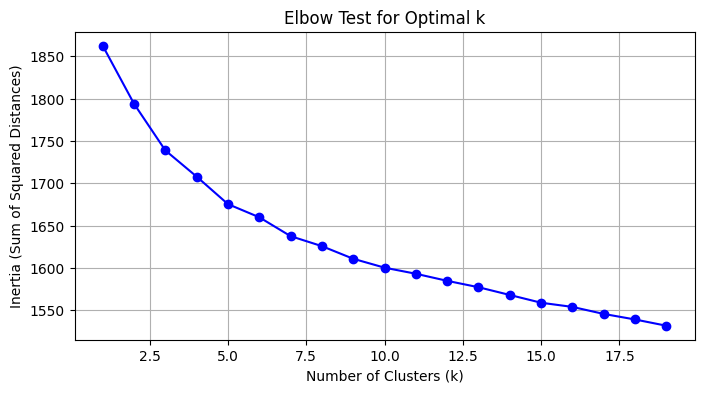

In [21]:
affordable_housing_embeddings, affordable_housing_sentences = get_embeddings('has_affordablehousing')
elbow_test(affordable_housing_embeddings)

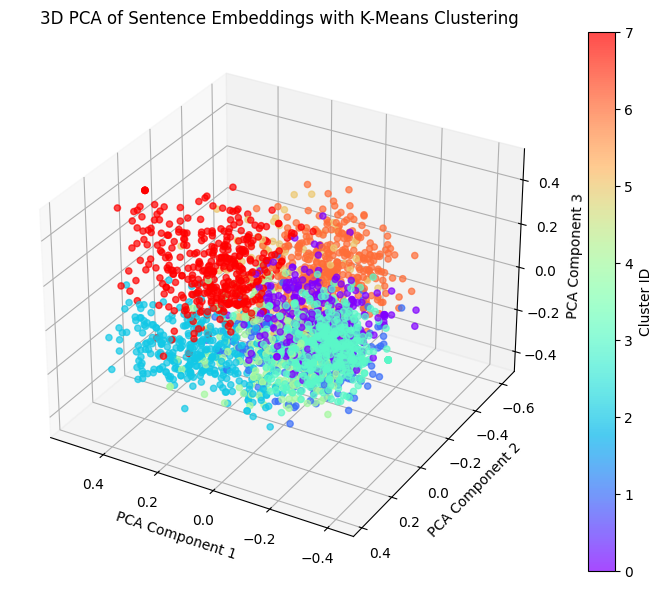

In [22]:
affordable_housing_num_clusters = 8
affordable_housing_seed = 42
affordable_housing_clusters = k_means_classifier(affordable_housing_embeddings, affordable_housing_num_clusters, affordable_housing_seed)
affordable_housing_clusters_df = pd.DataFrame({'Sentence': affordable_housing_sentences, 'Cluster': affordable_housing_clusters})
pca_plot(affordable_housing_embeddings, affordable_housing_clusters)

In [23]:
affordable_housing_example_sentences = 4
example_sentences(affordable_housing_clusters_df, affordable_housing_num_clusters, affordable_housing_example_sentences)


Cluster 0:
- Personally, I would love to seehousing and especially affordable housing in the city and especially in this area of the city.
- We cant afford, I mean, we cant afford the cost of living here to raise.
- People cannot afford, I live in a four unit building, Ive lived there for 20 years.
- After 35 years, faithfully paying rent to live in one of five charming Hollywood bungalows, I am being displaced and losing my home to make way for a 27-unit luxuryas in high priced condo complex.

Cluster 1:
- I believe the letter mentioned a desire that all projects that are using the bonus FAR be required to provide affordable housing, not just the ones that are what we seelargely residential or at least 30 residential.
- Affordable housing is a very important thingsomething that I think all of us on the commission certainly for those of us who came in with father Cezios have been passionately concerned and frustrated about from our position as commissioners.
- But it correct the way t

In [24]:
affordable_housing_cluster_labels = {
    0: "*affordable housing design/infrastructure relative to the proposed project",
    1: "",
    2: "*concern about lack of affordable housing",
    3: "*issues and inadequacies of affordable housing on community",
    4: "physical location of affordable housing",
    5: "*beauracracy, compliance with regulations, application",
    6: "affordable housing regulations and requirements for different zones or businesses",
    7: "*specific amount affordable housing space requirements"
}


affordable_housing_cluster_breakdown_df = display_cluster_breakdown(affordable_housing_clusters_df, affordable_housing_cluster_labels)
affordable_housing_cluster_breakdown_df

,Pct of Sentences,Manual Guessed Label
Cluster,,
0,11.07%,*affordable housing design/infrastructure rela...
1,12.97%,
2,13.38%,*concern about lack of affordable housing
3,16.45%,*issues and inadequacies of affordable housing...
4,11.93%,physical location of affordable housing
5,5.64%,"*beauracracy, compliance with regulations, app..."
6,13.98%,affordable housing regulations and requirement...
7,14.58%,*specific amount affordable housing space requ...


Topic: Neighborhood Character

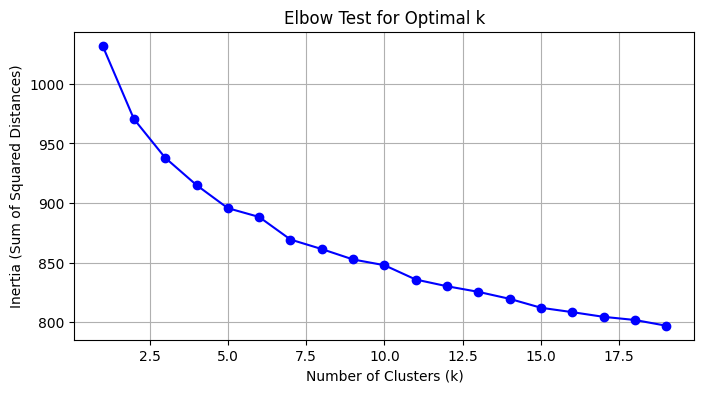

In [25]:
neighborhood_char_embeddings, neighborhood_char_sentences = get_embeddings('has_nhood_character')
elbow_test(neighborhood_char_embeddings)

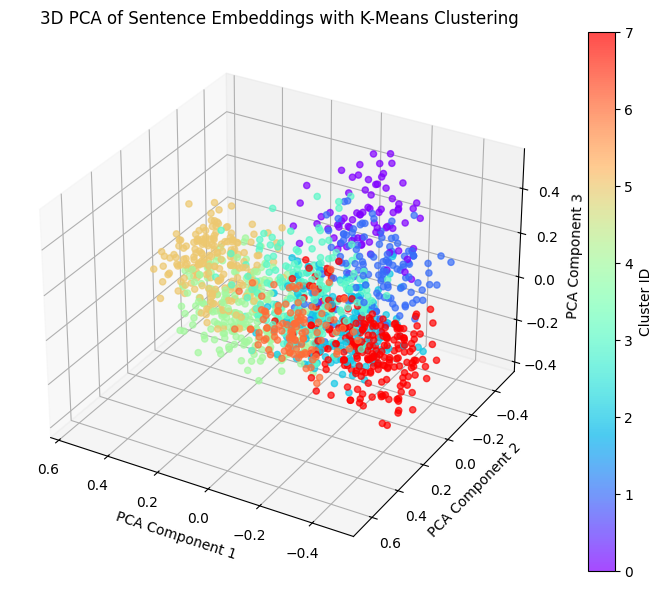

In [26]:
neighborhood_char_num_clusters = 8
neighborhood_char_seed = 42
neighborhood_char_clusters = k_means_classifier(neighborhood_char_embeddings, neighborhood_char_num_clusters, neighborhood_char_seed)
neighborhood_char_clusters_df = pd.DataFrame({'Sentence': neighborhood_char_sentences, 'Cluster': neighborhood_char_clusters})
pca_plot(neighborhood_char_embeddings, neighborhood_char_clusters)

In [27]:
neighborhood_char_example_sentences = 4
example_sentences(neighborhood_char_clusters_df, neighborhood_char_num_clusters, neighborhood_char_example_sentences)


Cluster 0:
- This illegal displacement has caused my family numerous hardships.
- Also in relation to seismic, the staff recommendation reports that there is a potential for horizontal and vertical displacement of 10 and 2 inches.
- Thats eight blocks away via Carlotta, 50 units, nine blocks away displaced.
- We do not wish or desire to terminate anyones tendency to evict anyone to displace anyone thats not the intentof this.

Cluster 1:
- Being at condition number 11, the applicant shall not displace or evict apartment tenants with existing actively-sigurements, including month to month leases.
- I just think its too vague to saythe applicant shall not displace or evict apartment tenants with existing active lease agreements, including month to month lease as just in a vacuum, because I think its all obvious to everyone here that they can.
- This staff response sides that the article does not reference any commutative impacts instead generally discusses loan-come family displacement 

In [28]:
neighborhood_char_cluster_labels = {
    0: "*neighborhood character design/infrastructure relative to the proposed project",
    1: "",
    2: "*concern about lack of neighborhood character",
    3: "*issues and inadequacies of neighborhood character on community",
    4: "physical location of neighborhood character",
    5: "*beauracracy, compliance with regulations, application",
    6: "neighborhood character regulations and requirements for different zones or businesses",
    7: "*specific amount neighborhood character space requirements"
}


neighborhood_char_cluster_breakdown_df = display_cluster_breakdown(neighborhood_char_clusters_df, neighborhood_char_cluster_labels)
neighborhood_char_cluster_breakdown_df

,Pct of Sentences,Manual Guessed Label
Cluster,,
0,5.60%,*neighborhood character design/infrastructure ...
1,9.97%,
2,15.57%,*concern about lack of neighborhood character
3,14.19%,*issues and inadequacies of neighborhood chara...
4,15.57%,physical location of neighborhood character
5,14.92%,"*beauracracy, compliance with regulations, app..."
6,7.71%,neighborhood character regulations and require...
7,16.45%,*specific amount neighborhood character space ...
